In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from helpers import load_config
import seaborn as sns
import matplotlib.pyplot as plt

configs = load_config(os.path.join("configs", "configs.yaml"))

study_path = configs["STORAGE_DIR_STUDY2"]

Vanilla copy-paste of first few cells of 03_colorectal_multiclass.ipynb to get dataframe of all records, including censored records.

In [3]:
patientdf = pd.read_csv(
    os.path.join(configs["STORAGE_DIR_STUDY2"], "data_clinical_patient.txt"),
    sep="\t",
    header=4
)
patientdf.head()

columns_being_discarded =  [
    # 'SUBTYPE', # consider for later analysis
    'CANCER_TYPE_ACRONYM', # same value for all records
    'OTHER_PATIENT_ID', # id column not related to any data of our interest
    'AJCC_STAGING_EDITION', # version of handbook used for classification
    'DAYS_LAST_FOLLOWUP', # similar but more relevant information captured in OS_Months
    'DAYS_TO_BIRTH', # age captures similar information 
    'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', # similar but more relevant information captured in OS_Months 
    'ETHNICITY', # race column has more rich data
    'FORM_COMPLETION_DATE', # irrelevant to analysis
    'HISTORY_NEOADJUVANT_TRTYN', # highly skewed, 590 No, 2 Yes, 2 Null
    'ICD_O_3_HISTOLOGY' , # which edition of certain code used for tabulating data
    'ICD_O_3_SITE', # which edition of certain code used for tabulating data
    'INFORMED_CONSENT_VERIFIED', # irrelevant to analysis
    'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', # highly skewed 557 Yes, 19 No, 18 Null
    'IN_PANCANPATHWAYS_FREEZE', # if patient is part of a certain analysis, irrelevant
    ]

patientdf_1 = patientdf.drop(columns=columns_being_discarded)

sampledf = pd.read_csv(
    os.path.join(configs["STORAGE_DIR_STUDY2"], "data_clinical_sample.txt"),
    sep="\t",
    header=4
)

columns_being_discarded_sampledf = [
    'TISSUE_PROSPECTIVE_COLLECTION_INDICATOR', # when sample was collected, before or after
    'TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR', # when sample was collected, before or after
    'TISSUE_SOURCE_SITE_CODE', # which hospital was the sample collected at
    'TUMOR_TISSUE_SITE', # part of body where sample was collected
    'SAMPLE_TYPE', # has only one value "Primary"
    'TISSUE_SOURCE_SITE' # which hospital was the sample collected at
]

sampledf_1 = sampledf.drop(columns=columns_being_discarded_sampledf)

df = pd.merge(patientdf_1, sampledf_1, on='PATIENT_ID', how='inner')

columns_to_drop = [
    'GRADE',
    'DFS_MONTHS', 'DFS_STATUS',
    'SUBTYPE', 'ICD_10',
    'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT',
    'DSS_STATUS', 'DSS_MONTHS',
    'AJCC_PATHOLOGIC_TUMOR_STAGE',
    'SOMATIC_STATUS',
    'TUMOR_TYPE',
    'CANCER_TYPE',
    'RACE',
    'CANCER_TYPE_DETAILED', 
    "OS_STATUS", "OS_MONTHS"
]

df = df.drop(columns=columns_to_drop)

In [4]:
df1 = df[df["PFS_STATUS"] == "0:CENSORED"]
print(f"Records with censored data: {df1.shape}")
df1 = df1[df1["PFS_MONTHS"] > 36]
print(f"Records with censoring after 36 months: {df1.shape}")
df1 = df1.dropna()
print(f"Records after removing rows with nulls: {df1.shape}")

Records with censored data: (441, 19)
Records with censoring after 36 months: (99, 19)
Records after removing rows with nulls: (32, 19)


/var/folders/_0/qrjsyj4n0r951n63lt8qdzrc0000gn/T/ipykernel_85060/2884278012.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1['PFS_MONTHS'], shade=True, color='coral')


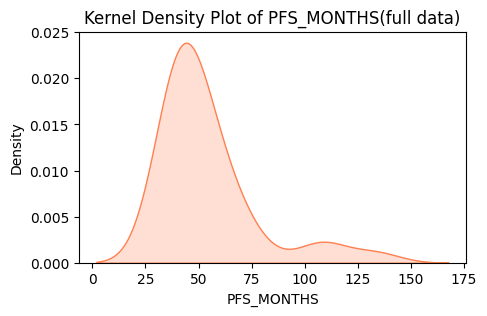

In [5]:
# Kernel Density Plot
plt.figure(figsize=(5, 3))
sns.kdeplot(df1['PFS_MONTHS'], shade=True, color='coral')
plt.title('Kernel Density Plot of PFS_MONTHS(full data)')
plt.xlabel('PFS_MONTHS')
plt.ylabel('Density')
plt.show()


/var/folders/_0/qrjsyj4n0r951n63lt8qdzrc0000gn/T/ipykernel_85060/374112233.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df2['PFS_MONTHS'], shade=True, color='coral')


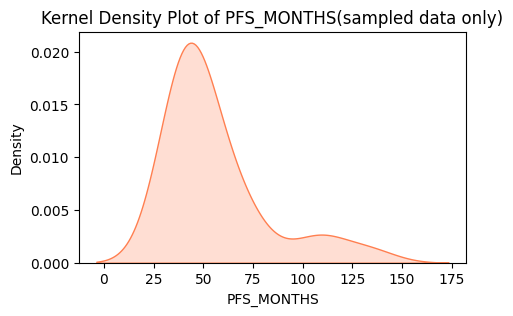

In [6]:
df2 = df1.sample(n=25, random_state=1)

# Kernel Density Plot
plt.figure(figsize=(5, 3))
sns.kdeplot(df2['PFS_MONTHS'], shade=True, color='coral')
plt.title('Kernel Density Plot of PFS_MONTHS(sampled data only)')
plt.xlabel('PFS_MONTHS')
plt.ylabel('Density')
plt.show()


In [7]:
old_data = pd.read_csv(
    os.path.join(study_path, "pathological_df.csv")
)

df2 = df2.drop("PFS_STATUS", axis=1)

new_data = pd.concat([old_data, df2])
new_data.shape

(88, 18)

In [8]:
new_data.to_csv(
    os.path.join(study_path, "pathological_df_v2.csv"),
    index=False
)